# Lab 3
## Ian Grant

In [105]:
import requests, json, numpy, os
import matplotlib.pyplot as plt

In [106]:
#Set working directory
os.chdir("/home/ian/Documents/geocomp_1/lab_2/output")

In [107]:
#Import the data
url = "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_5m.json"

In [108]:
with requests.get(url) as response:
    data = response.json()
    # Two different ways of composing text messages. The format function is preferred.
    print('Number of Counties in US: ' + str(len(data['features'])))
    print('First entry is {}'.format(data['features'][0]['properties']['NAME']))

Number of Counties in US: 3221
First entry is Valdez-Cordova


### Extracting the 'properties' dictionaries

Based on the results of the analysis presented in Lab 2, we only need to deal with the 'properties' dictionaries within 'data'. This is a relatively small part of the data file, since most of the data is geometric coordinates. Therefore, the first step is to make a list of just the 'properties' dictionaries.

In [109]:
counties_props = []

In [110]:
for county in data['features']:
    counties_props.append(county['properties'])

We no longer need to store the whole input file in 'data', but I have left this commented for convenience
del(data)

### Aggregating the counties

First, I define a function called aggDict() that takes a list of dictionaries that have at least one key in common. It returns a new dictionary where the keys are all the unique values of the selected common key. 

For example, if we use aggDict() on the list of counties dictionaries using the 'STATE' key, the function will return a dict with one key for each state name. The value of each key will be a list of all the counties in that state (see the analysis by state below).

In [111]:
def aggDict(dict_list, common_key):
    # Aggregate a list of dictionaries by one of their common keys.

    # Arguments:
    # dict_list -- A list of dicts; all dicts must include at least one common key.
    # commmon_key -- The key by which to aggregate the list of dictionaries; all dicts in  dict_list must contain common_key.

    # Returns:
    # dict: {each unique value corresponding to common_key : [matching dicts from list_dict]} -- Aggregated dictionary. Keys are the set of unique values of common_key. Values are lists of all the dicts in list_dict that match each value of common_key.
   
    agg_dict = {}

    #create a set of all the unique values corresponding to common_key
    common_key_values = {listed_dict[common_key] for listed_dict in dict_list}
    
    #initialize dictionary with unique values as keys and empty lists as values
    agg_dict = {common_key_value:[] for common_key_value in common_key_values}

    #update the values for each key in the dict
    for listed_dict in dict_list:
        #append the properties dict of the current county to the value of the appropriate agg_dict key
        agg_dict[listed_dict[common_key]].append(listed_dict)

    return agg_dict

### Calculating the most frequent values

Next, we'll make a function that uses an aggegated dictionary to return a sorted list of the n keys with the most counties.

Taking our state example above, we could use this function with the dictionary aggregated by state to return the five states with the most counties.

In [112]:
def frequentValues(agg_dict, n):
    # Returns a sorted list of the n keys in an aggregated dictionary that correspond to the largest values.
    
    # Arguments:
    # agg_dict -- An aggregated dictionary; see aggDict().
    # n -- number of keys to return; -1 returns all keys
    
    # Returns:
    # list[n keys of agg_dict corresponding to the longest values]: A list of keys  sorted in descending order by length of value list corresponding to each key. 
    
    #cap n at the length of the dictionary, and set to full length if n=-1
    if n > len(agg_dict) or n == -1:
        n = len(agg_dict)

     #Make a 2D array holding the n most common values and the number of counties for each value
     #This array will update as we search the dict 
    frequent_values = [[None, 0] for i in range(n)]

    for key in agg_dict:
        #calculate the number of counties in the current key of the aggregated dictionary
        value_count = len(agg_dict[key])

        frequent_values_counts = [frequent_value[1] for frequent_value in frequent_values]

        if value_count > min(frequent_values_counts):
            index = frequent_values_counts.index(min(frequent_values_counts))
            frequent_values[index] = [key, value_count]

    sorted_frequent_values = sorted(frequent_values, key=lambda row : row[1], reverse=True)
    sorted_frequent_values_keys = [key[0] for key in sorted_frequent_values]
    
    return sorted_frequent_values_keys

Next, let's make a function to visually display the n most frequent keys in an aggregated dictionary.

In [138]:
# Plot an aggregated dictionary with key values on x-axis and frequencies on y-axis
def aggDictPlot(agg_dict, x_title, n=10, save=False, xAlias=lambda x : x):
    # Shows (and optionally saves) the frequency of occurences in an aggregated dict.
                
    # Arguments:
        # agg_dict: The aggregated dictionary to plot (see aggDict())
        # x_title: The title of the x-axis.
        # n: The number of keys of the aggregated dictionary to plot; the top n most frequent keys will be plotted.
        # save: If true, plot will be saved to .png file.
        # xAlias: Optional function for providing alternate names for the x labels (e.g. state names instead of state codes)
                
    plt.close() #closes previous figures if any are open; avoids data from multiple function calls being combined into single figure, but maybe there's a better way
    
    #isSubset is true if n is set to plot only a subset of the key values in agg_dict
    isSubset = n < len(agg_dict)
    
    if isSubset:
        keys_to_plot = frequentValues(agg_dict, n)
    else: 
        #returns all keys sorted by frequency
        keys_to_plot = frequentValues(agg_dict, -1)
        
    frequencies = [len(agg_dict[key]) for key in keys_to_plot]

    #set title of plot
    if isSubset:
        title = f"Top {n} Most Frequent Values of {titleLabelStyle(x_title)}"
    else:
        title = f"Frequency of All Unique Values of {titleLabelStyle(x_title)}"

    keys_to_plot_alias = [xAlias(key) for key in keys_to_plot] 
    
    #make plot
    plt.bar(keys_to_plot_alias, frequencies)
    plt.title(title)
    plt.xlabel(x_title)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Frequency")

    #save or show plot
    if save:
        #replace spaces and slashes for filename
        filename = filenameStyle(title)
        plt.savefig(f"{filename}.png", bbox_inches="tight", pad_inches=.5)
    else:
        plt.show()

In [114]:
#Capitalization rules for the plot title                
def titleLabelStyle(title_label):
    if title_label.isupper():
        return title_label
    else:
        return title_label.title()

In [115]:
#Formatting rules for filename
def filenameStyle(title_label):
    return title_label.title().replace(" ", "_").replace("/", "-").replace("\\","-")

### State codes dictionary

Before we continue, let's define a dictionary of all the state codes so that we can display the states by name.

In [116]:
state_codes_def = """01,Alabama
02,Alaska
04,Arizona
05,Arkansas
06,California
08,Colorado
09,Connecticut
10,Delaware
11,District of Columbia
12,Florida
13,Georgia
15,Hawaii
16,Idaho
17,Illinois
18,Indiana
19,Iowa
20,Kansas
21,Kentucky
22,Louisiana
23,Maine
24,Maryland
25,Massachusetts
26,Michigan
27,Minnesota
28,Mississippi
29,Missouri
30,Montana
31,Nebraska
32,Nevada
33,New Hampshire
34,New Jersey
35,New Mexico
36,New York
37,North Carolina
38,North Dakota
39,Ohio
40,Oklahoma
41,Oregon
42,Pennsylvania
44,Rhode Island
45,South Carolina
46,South Dakota
47,Tennessee
48,Texas
49,Utah
50,Vermont
51,Virginia
53,Washington
54,West Virginia
55,Wisconsin
56,Wyoming
72,Puerto Rico"""

In [117]:
#Parse defintion string into 2D list of format [[code1, state1], [code2, state2], etc.]
state_codes_def = state_codes_def.split('\n')
for i in range(len(state_codes_def)):
    state_codes_def[i] = state_codes_def[i].split(',')

In [118]:
#Create state codes dictionary
state_codes = {}
for pair in state_codes_def:
    state_codes[pair[0]] = pair[1]

We can also make a function that will take the state code and return the state.
This will come in handy for plots later.

In [119]:
def stateName(key):
    return state_codes[key]

## County names analysis

We can use these functions to aggregate counties by county name and then look at the three most frequently occuring counties. 

We can see that "Washington" is first, "Jefferson" is second, and "Franklin" is third, and we can verify this by checking the number of counties that appear for each key. 

In [120]:
county_dict = aggDict(counties_props, 'NAME')
common_county_names = frequentValues(county_dict, 3)

In [121]:
for county_name in common_county_names:
    print(f"There are {len(county_dict[county_name])} {county_name} Counties.")

There are 31 Washington Counties.
There are 26 Jefferson Counties.
There are 26 Franklin Counties.


We can use the resulting list of county names to get more information about those counties.

In [122]:
#Iterate through list of most common names
for county_name in common_county_names:
    #Print states where each county name appears
    print(f"There are {len(county_dict[county_name])} {county_name} Counties, one each in the following states:\n {[state_codes[county['STATE']] for county in county_dict[county_name]]} \n")

There are 31 Washington Counties, one each in the following states:
 ['Colorado', 'Florida', 'Arkansas', 'Illinois', 'Iowa', 'Maine', 'Maryland', 'Missouri', 'Tennessee', 'Oklahoma', 'Oregon', 'Wisconsin', 'Utah', 'Vermont', 'Kansas', 'Indiana', 'Kentucky', 'Minnesota', 'Georgia', 'Alabama', 'Louisiana', 'Idaho', 'New York', 'North Carolina', 'Nebraska', 'Mississippi', 'Pennsylvania', 'Ohio', 'Rhode Island', 'Virginia', 'Texas'] 

There are 26 Jefferson Counties, one each in the following states:
 ['Illinois', 'Georgia', 'Iowa', 'Oregon', 'Colorado', 'Arkansas', 'Florida', 'Kansas', 'Kentucky', 'Alabama', 'Louisiana', 'Mississippi', 'Idaho', 'Indiana', 'Missouri', 'Tennessee', 'Texas', 'New York', 'Oklahoma', 'Nebraska', 'Montana', 'Pennsylvania', 'Ohio', 'West Virginia', 'Wisconsin', 'Washington'] 

There are 26 Franklin Counties, one each in the following states:
 ['Georgia', 'Alabama', 'Indiana', 'Idaho', 'Kentucky', 'Iowa', 'Mississippi', 'New York', 'Texas', 'Arkansas', 'Florida',

Interestingly, there are two Franklin Counties for state code 51 (Virginia). I wanted to be sure this was not an error in my analysis, so I checked the corresponding entries in the counties_props list. 

We can see that there are indeed two distinct county entries that differ in the 'LSAD' property: one is marked as a 'County' and the other is marked as a 'city'. 

In [123]:
ans = []

In [124]:
for county in counties_props:
    #print(county['NAME'])
    if county['NAME'] == 'Franklin' and county['STATE'] == '51':
        ans.append(county)

In [125]:
for county in ans:
    print(county)

{'GEO_ID': '0500000US51067', 'STATE': '51', 'COUNTY': '067', 'NAME': 'Franklin', 'LSAD': 'County', 'CENSUSAREA': 690.426}
{'GEO_ID': '0500000US51620', 'STATE': '51', 'COUNTY': '620', 'NAME': 'Franklin', 'LSAD': 'city', 'CENSUSAREA': 8.206}


LSAD stands for 'Legal/Statistical Area Description'. It is a US Census designation that describes types of entities.

The fact that there are two Franklins in Virginia, one with LSAD "County" and the other "city", raises a question about the data: why are some entries listed as LSAD type "County" but others not? How many LSAD types are included in this dataset?

We can use the same methods as above to anwer these questions.

In [126]:
LSAD_dict = aggDict(counties_props, 'LSAD')
for LSAD in LSAD_dict:
    print(f"There are {len(LSAD_dict[LSAD])} counties of type {LSAD}.")

There are 2 counties of type .
There are 12 counties of type Borough.
There are 78 counties of type Muno.
There are 4 counties of type Cty&Bor.
There are 11 counties of type CA.
There are 41 counties of type city.
There are 2 counties of type Muny.
There are 64 counties of type Parish.
There are 3007 counties of type County.


We can see that there are 3,007 entries of type "County," as we would expect, but more than a hundred entries with other LSAD values. We would have to know more about the dataset to understand why, but it's interesting to note that not all of the putative counties are listed as such.

## State-by-state analysis

Next, we will examine state-level statistics. We can apply the same functions as above but aggregate on state code rather than county name. 

We can also see the top 5 states with the most counties using the same function as above.

In [127]:
#Create dictionary aggregated by state code
state_dict = aggDict(counties_props, 'STATE')

In [128]:
print(f"The five states with the most counties are: {[state_codes[state] for state in frequentValues(state_dict, 5)]})")

The five states with the most counties are: ['Texas', 'Georgia', 'Virginia', 'Kentucky', 'Missouri'])


Next, we can use the state dictionary to calculate state statistics, writing the results to an output file.

In [129]:
#open the output file for writing (which clears the existing data in the file)
output_file = open("counties_analysis_by_state.txt", "w")

In [130]:
for state_code in frequentValues(state_dict, -1): #with n=-1, frequentValues() gives a list of all the  keys sorted by frequency

    #state is the list of all counties in the state corresponding to state_code
    state = state_dict[state_code]

    #calculate how many counties are in this state
    num_counties = len(state)

    #get list of just the county areas in this state
    area_list = [county['CENSUSAREA'] for county in state]

    #calculate the mean of the county areas
    mean_area = sum(area_list) / len(area_list)

    #identify largest and smallest counties
    smallest_county = state[area_list.index(min(area_list))]
    biggest_county = state[area_list.index(max(area_list))]
    
    output_file.write(f"The mean area of the {num_counties} counties in {state_codes[state_code]} is {round(mean_area, 2)}.\n")
    output_file.write(f"The smallest is {smallest_county['NAME']} County, with an area of {smallest_county['CENSUSAREA']}.\n")
    output_file.write(f"The largest is {biggest_county['NAME']} County, with an area of {biggest_county['CENSUSAREA']}.\n\n")

In [131]:
#close the output file
output_file.close()

In [132]:
#open the output file again for reading
output_file = open("counties_analysis_by_state.txt", "r")

In [133]:
#print the first 1000 characters of the output file
print(output_file.read(1000))

The mean area of the 254 counties in Texas is 1028.47.
The smallest is Rockwall County, with an area of 127.036.
The largest is Brewster County, with an area of 6183.733.

The mean area of the 159 counties in Georgia is 361.72.
The smallest is Clarke County, with an area of 119.2.
The largest is Ware County, with an area of 892.461.

The mean area of the 134 counties in Virginia is 294.7.
The smallest is Falls Church County, with an area of 1.999.
The largest is Pittsylvania County, with an area of 968.941.

The mean area of the 120 counties in Kentucky is 329.05.
The smallest is Robertson County, with an area of 99.911.
The largest is Pike County, with an area of 786.833.

The mean area of the 115 counties in Missouri is 597.75.
The smallest is St. Louis County, with an area of 61.909.
The largest is Texas County, with an area of 1177.266.

The mean area of the 105 counties in Kansas is 778.65.
The smallest is Wyandotte County, with an area of 151.6.
The largest is Butler County, with

In [134]:
output_file.close()

### Plotting the aggregated dictionaries
Finally, we can use the aggDictPlot() function to take a look at dictionaries we've made so far. 
First, let's look at the top 20 most frequent county names.
Note that the plotting  function properly capitalizes 'county' even though it is lowercase in the function call.         

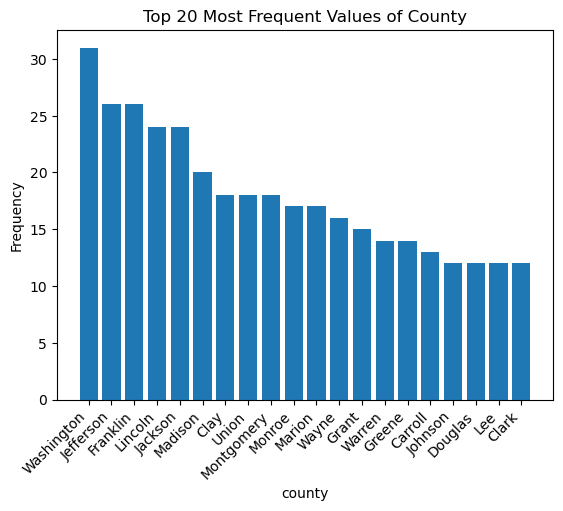

In [139]:
aggDictPlot(county_dict, 'county', save=True, n=20)

Next, we can do the same for states, using the default number of elements to plot and the stateName function to get the state names from the state codes. 


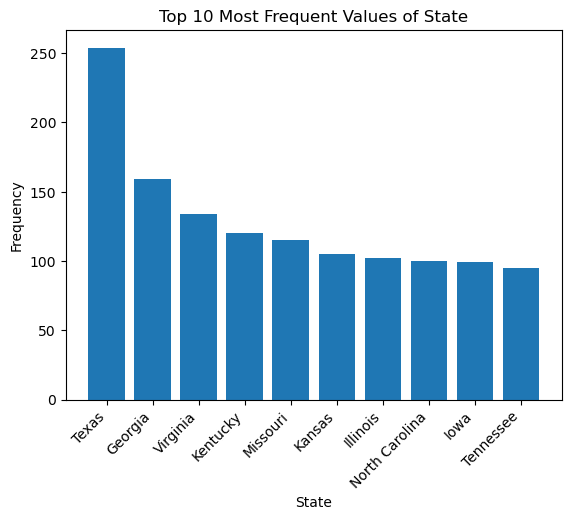

In [140]:
aggDictPlot(state_dict, 'State', save=True, xAlias=stateName)

Finally, in the case of the LSAD function, the plot can tell that all of the elements are plotted, so the title changes accordingly.

Also note that the plotting function corrects the lowercase "a" in the function call for "area" below.


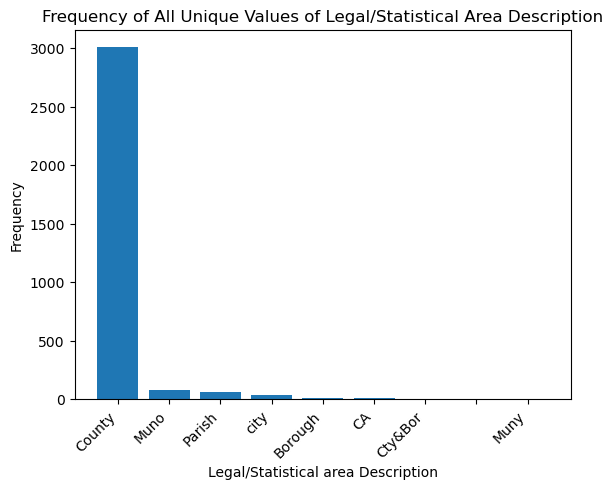

In [141]:
aggDictPlot(LSAD_dict, 'Legal/Statistical area Description', save=True)

These three plots can also be found as .png files in the working directory.